# 0. Import Library

In [52]:
# Basic Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Scikit-learn: Data Splitting, Preprocessing, Evaluation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Scikit-learn: Regression Models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

# Boosting Libraries
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# SciPy: Optimization
from scipy.optimize import minimize

# PyTorch: Model Training and Utilities
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# 1. Loda Data

In [ ]:
df = pd.read_csv("chemical.csv")

X = df.drop(columns=['ECH_target'])
y = df['ECH_target']

X_train, X_all, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, shuffle=True
)

# 2. Prediction Model

## 2-1. Other Prediction Models

▶ Training LinearRegression


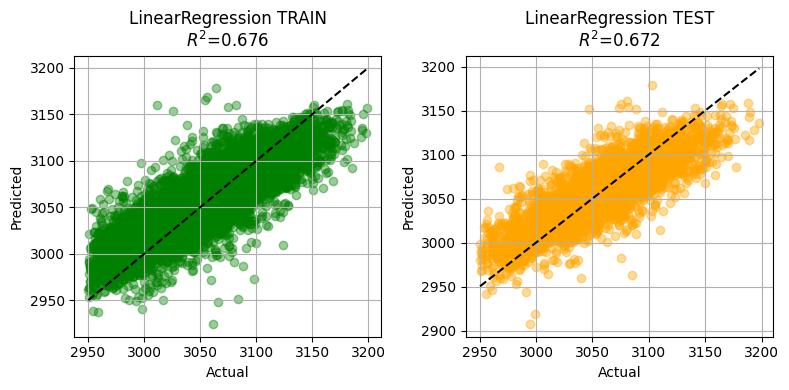

▶ Training DecisionTree


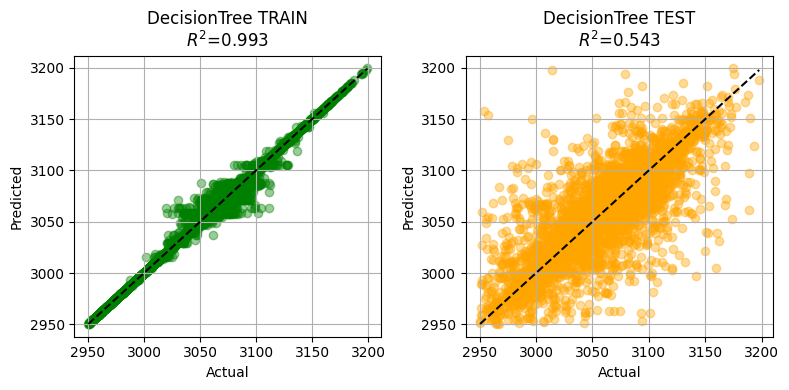

▶ Training RandomForest


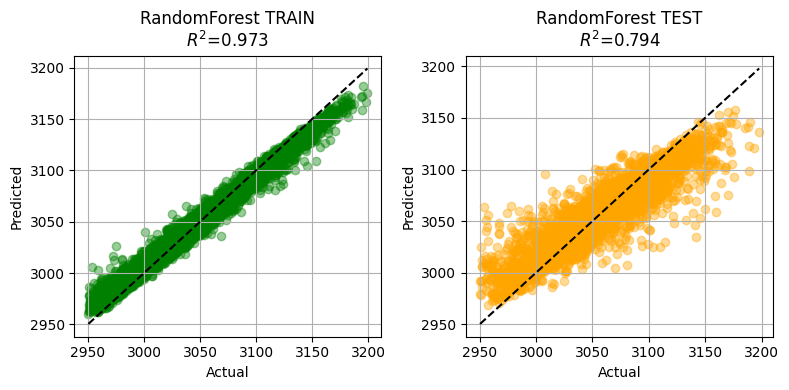

▶ Training GradientBoosting


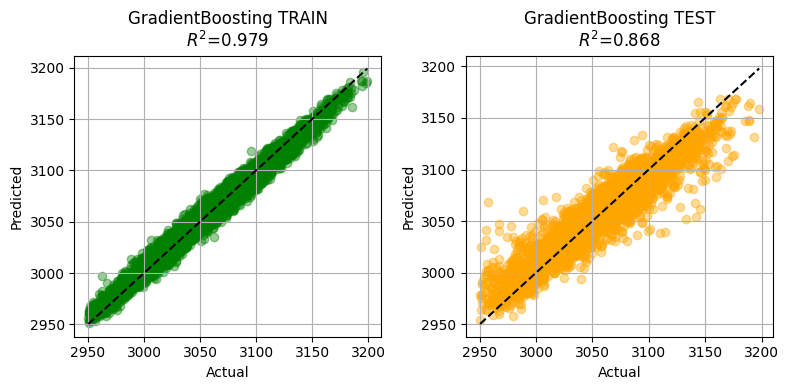

▶ Training XGBoost


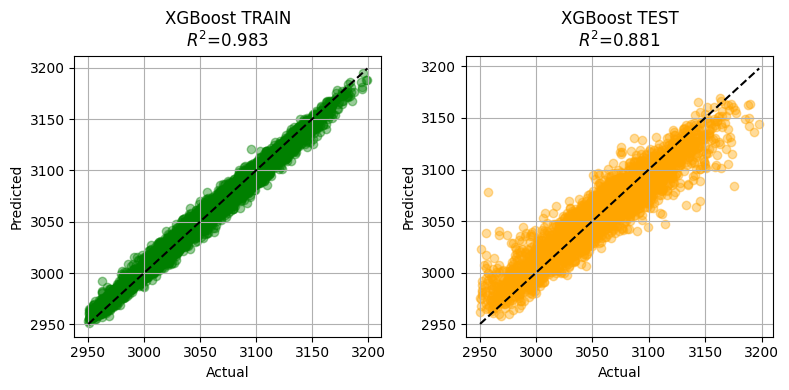

,Model,MAE_train,MAE_test,RMSE_train,RMSE_test,R2_train,R2_test
4,XGBoost,4.251197,10.681129,5.548679,14.661278,0.983090,0.881005
3,GradientBoosting,4.874187,11.296404,6.249814,15.437498,0.978546,0.868071
2,RandomForest,4.930396,13.557408,6.974549,19.292334,0.973282,0.793958
0,LinearRegression,18.540064,18.587841,24.283732,24.332158,0.676106,0.672247
1,DecisionTree,1.050518,18.779887,3.584466,28.737298,0.992943,0.542830


In [51]:


X = df.drop(columns=['ECH_target'])
y = df['ECH_target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, shuffle=True
)

num_cols = X.columns.tolist()
prep = ColumnTransformer([('scale', StandardScaler(), num_cols)])

models = {
    'LinearRegression': Pipeline([('prep', prep), ('model', LinearRegression())]),
    'DecisionTree': Pipeline([('prep', prep),
                              ('model', DecisionTreeRegressor(
                                  max_depth=20, random_state=42))]),
    'RandomForest': Pipeline([('prep', prep),
                              ('model', RandomForestRegressor(
                                  n_estimators=1000, random_state=42, n_jobs=-1))]),
    'GradientBoosting': Pipeline([('prep', prep),
                                  ('model', GradientBoostingRegressor(
                                      n_estimators=1000, learning_rate=0.05,
                                      max_depth=5, random_state=42))]),
    'XGBoost': Pipeline([('prep', prep),
                         ('model', XGBRegressor(
                             n_estimators=1000, learning_rate=0.05,
                             max_depth=5, subsample=0.8, colsample_bytree=0.8,
                             objective='reg:squarederror', random_state=42,
                             n_jobs=-1))]),
}

results = []

for name, pipe in models.items():
    print(f'▶ Training {name}')
    pipe.fit(X_train, y_train)

    pred_tr = pipe.predict(X_train)
    pred_te = pipe.predict(X_test)

    results.append({
        'Model': name,
        'MAE_train': mean_absolute_error(y_train, pred_tr),
        'MAE_test':  mean_absolute_error(y_test,  pred_te),
        'RMSE_train': np.sqrt(mean_squared_error(y_train, pred_tr)),
        'RMSE_test':  np.sqrt(mean_squared_error(y_test,  pred_te)),
        'R2_train':   r2_score(y_train, pred_tr),
        'R2_test':    r2_score(y_test,  pred_te)
    })

    fig, axes = plt.subplots(1, 2, figsize=(8, 4))  

    # Train
    axes[0].scatter(y_train, pred_tr, alpha=0.4, color='green')
    lims = [y_train.min(), y_train.max()]
    axes[0].plot(lims, lims, 'k--')
    axes[0].set_title(f'{name} TRAIN\n$R^2$={r2_score(y_train, pred_tr):.3f}')
    axes[0].set_xlabel('Actual')
    axes[0].set_ylabel('Predicted')

    # Test
    axes[1].scatter(y_test, pred_te, alpha=0.4, color='orange')
    lims = [y_test.min(), y_test.max()]
    axes[1].plot(lims, lims, 'k--')
    axes[1].set_title(f'{name} TEST\n$R^2$={r2_score(y_test, pred_te):.3f}')
    axes[1].set_xlabel('Actual')
    axes[1].set_ylabel('Predicted')

    plt.tight_layout()
    plt.show()


results_df = pd.DataFrame(results).sort_values('MAE_test')
results_df

## 2-2. Prediction Model -  Neural Network

In [ ]:
scaler = StandardScaler().fit(X_train)
X_train_t = torch.tensor(scaler.transform(X_train), dtype=torch.float32)
y_train_t = torch.tensor(y_train.values.reshape(-1, 1), dtype=torch.float32)
X_test_t = torch.tensor(scaler.transform(X_all),  dtype=torch.float32)
y_test_t = torch.tensor(y_test.values.reshape(-1, 1), dtype=torch.float32)

train_loader = DataLoader(TensorDataset(X_train_t, y_train_t),
                          batch_size=64, shuffle=True)


class Net(nn.Module):
    def __init__(self, d_in):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_in, 64), nn.ReLU(),
            nn.Linear(64, 128),   nn.ReLU(),
            nn.Linear(128, 128),   nn.ReLU(),
            # nn.Linear(256, 128),   nn.ReLU(), fix above layer with (126,256) to get more layer -> better R square
            nn.Linear(128, 64),   nn.ReLU(),
            nn.Linear(64, 1),
        )

    def forward(self, x): return self.net(x)

Epoch    0 | train MSE 357789.5938 | val MSE 234212.0312
Epoch   20 | train MSE 3436.8884 | val MSE 5285.8945
Epoch   40 | train MSE 2984.0466 | val MSE 2319.2827
Epoch   60 | train MSE 650.2183 | val MSE 2092.0745
Epoch   80 | train MSE 1215.1870 | val MSE 983.0433
Epoch  100 | train MSE 505.9866 | val MSE 784.6147
Epoch  120 | train MSE 476.3954 | val MSE 1268.6565
Epoch  140 | train MSE 534.0206 | val MSE 755.2680
Epoch  160 | train MSE 307.5824 | val MSE 489.3327
Epoch  180 | train MSE 179.4010 | val MSE 405.2981
Epoch  200 | train MSE 229.0089 | val MSE 476.4666
Epoch  220 | train MSE 155.9102 | val MSE 426.0499
Epoch  240 | train MSE 111.6631 | val MSE 329.1444
Epoch  260 | train MSE 151.7154 | val MSE 352.7313
Epoch  280 | train MSE 136.7240 | val MSE 341.8529
Epoch  300 | train MSE 216.7739 | val MSE 327.3431
Epoch  320 | train MSE 161.0101 | val MSE 355.2592
Epoch  340 | train MSE 112.4097 | val MSE 303.6098
Epoch  360 | train MSE 99.2616 | val MSE 285.4040
Epoch  380 | train 

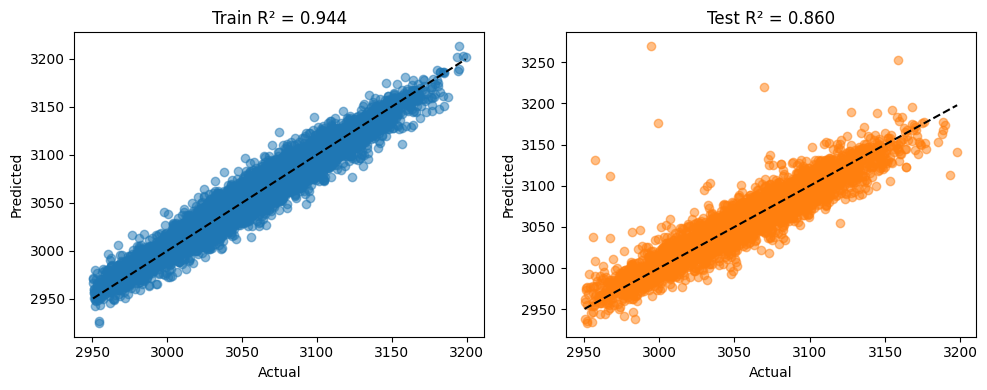

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Net(X_train_t.shape[1]).to(device)
crit = nn.MSELoss()
opt = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
sched = optim.lr_scheduler.ReduceLROnPlateau(opt, factor=0.5, patience=20)

best_val, wait, patience = float('inf'), 0, 50

for epoch in range(1000):
    model.train()
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad()
        loss = crit(model(xb), yb)
        loss.backward()
        opt.step()

    model.eval()
    with torch.no_grad():
        val_pred_pmc = model(X_test_t.to(device)).cpu()
        val_loss_pmc = crit(val_pred_pmc, y_test_t).item()
    sched.step(val_loss_pmc)

    if val_loss_pmc < best_val:
        best_val, wait = val_loss_pmc, 0
        torch.save(model.state_dict(), 'best_nn.pt')
    else:
        wait += 1
        if wait > patience:
            print(f'Early stop @ {epoch} | best val MSE {best_val:.4f}')
            break

    if epoch % 20 == 0:
        print(
            f'Epoch {epoch:4d} | train MSE {loss.item():.4f} | val MSE {val_loss_pmc:.4f}')

model.load_state_dict(torch.load('best_nn.pt'))
model.eval()
with torch.no_grad():
    y_train_pred = model(X_train_t.to(device)).cpu().numpy().ravel()
    y_test_pred = model(X_test_t.to(device)).cpu().numpy().ravel()

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test,  y_test_pred)

plt.figure(figsize=(10, 4))

# Train
plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred, alpha=0.5, color='blue')
lims = [y_train.min(), y_train.max()]
plt.plot(lims, lims, 'k--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'Train R² = {train_r2:.3f}')
plt.grid()

# Test
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred, alpha=0.5, color='orange')
lims = [y_test.min(), y_test.max()]
plt.plot(lims, lims, 'k--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'Test R² = {test_r2:.3f}')
plt.grid()

plt.tight_layout()
plt.show()

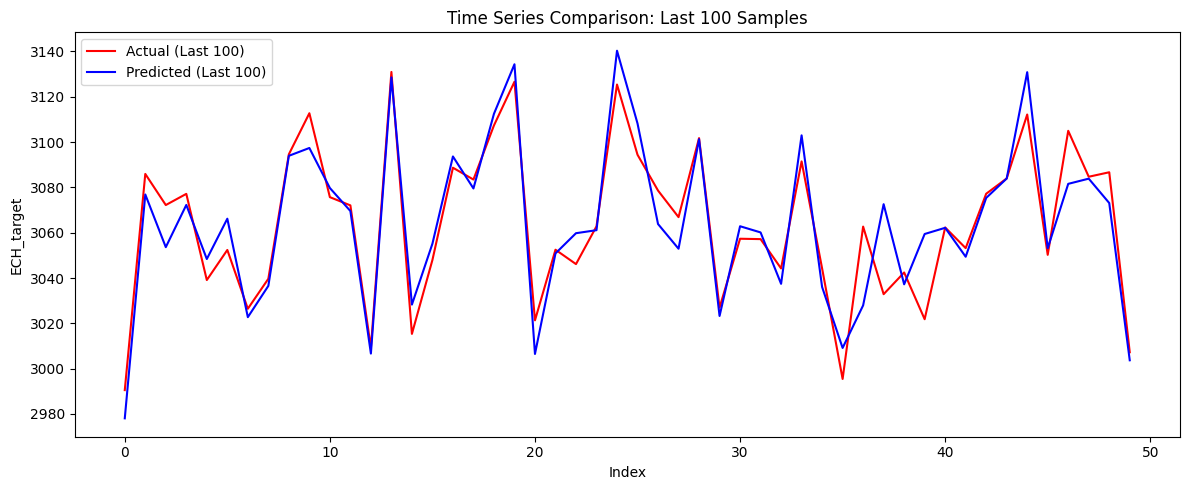

In [36]:
plt.figure(figsize=(12, 5))
plt.plot(y_test.reset_index(
    drop=True).values[-50:], label='Actual (Last 100)', color='red')
plt.plot(y_test_pred[-50:], label='Predicted (Last 100)', color='blue')
plt.title('Time Series Comparison: Last 100 Samples')
plt.xlabel('Index')
plt.ylabel('ECH_target')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

## 2-3. Prediction Model -  Neural Network with pattern matching

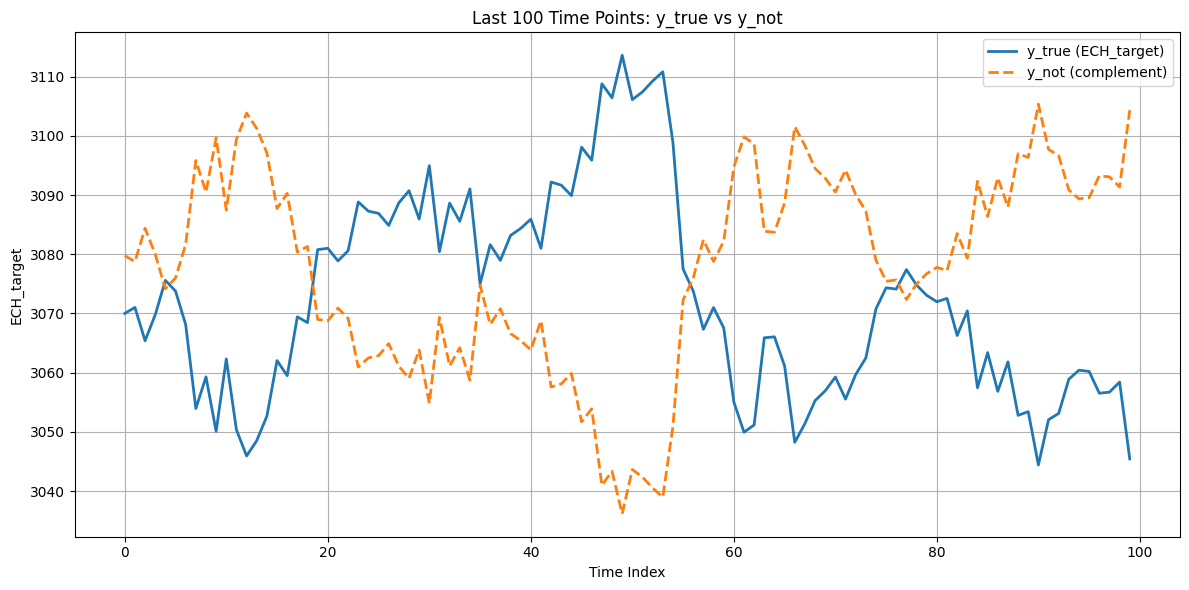

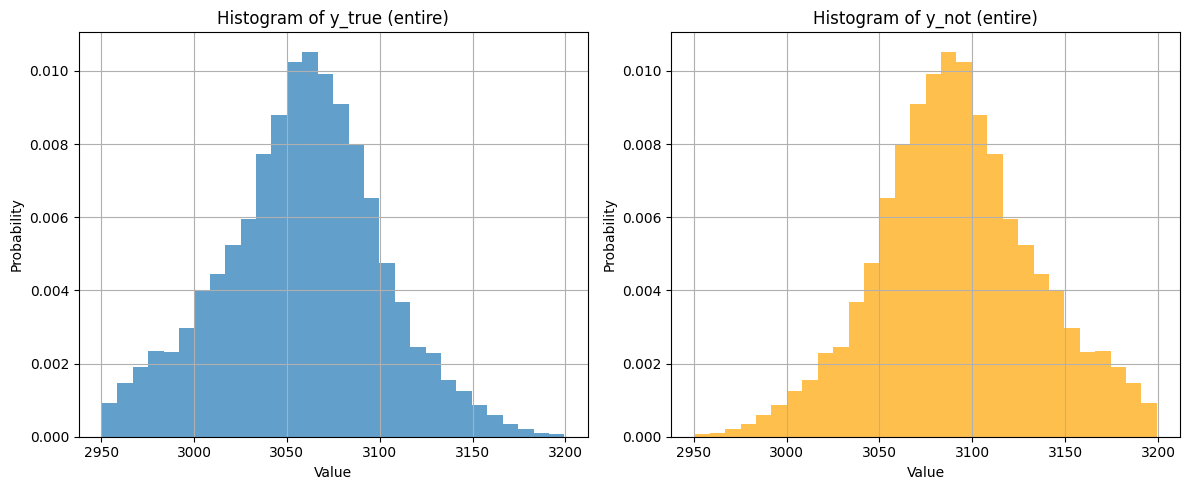

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


y_true = df['ECH_target'].values
y_max, y_min = np.max(y_true), np.min(y_true)
y_not = y_max + y_min - y_true

# Time series plot for last 100
plt.figure(figsize=(12, 6))
plt.plot(range(100), y_true[:100], label='y_true (ECH_target)', linewidth=2)
plt.plot(range(100), y_not[:100],
         label='y_not (complement)', linewidth=2, linestyle='--')
plt.title('Last 100 Time Points: y_true vs y_not')
plt.xlabel('Time Index')
plt.ylabel('ECH_target')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Histogram plot for entire data
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(y_true, bins=30, density=True, alpha=0.7, label='y_true')
plt.title('Histogram of y_true (entire)')
plt.xlabel('Value')
plt.ylabel('Probability')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(y_not, bins=30, density=True, alpha=0.7,
         label='y_not', color='orange')
plt.title('Histogram of y_not (entire)')
plt.xlabel('Value')
plt.ylabel('Probability')
plt.grid(True)

plt.tight_layout()
plt.show()

Epoch    0 | train MSE 167094.0156 | val MSE 237664.2500
Epoch   20 | train MSE 3377.0913 | val MSE 6311.0439
Epoch   40 | train MSE 1133.6091 | val MSE 2363.4307
Epoch   60 | train MSE 586.8995 | val MSE 1421.7957
Epoch   80 | train MSE 711.3110 | val MSE 1223.7034
Epoch  100 | train MSE 739.3946 | val MSE 919.7538
Epoch  120 | train MSE 453.5036 | val MSE 1019.0418
Epoch  140 | train MSE 614.5660 | val MSE 777.7430
Epoch  160 | train MSE 316.9117 | val MSE 664.0021
Epoch  180 | train MSE 140.0373 | val MSE 473.4440
Epoch  200 | train MSE 219.7994 | val MSE 489.6104
Epoch  220 | train MSE 228.9472 | val MSE 418.1936
Epoch  240 | train MSE 124.8796 | val MSE 368.7568
Epoch  260 | train MSE 144.2890 | val MSE 333.6829
Epoch  280 | train MSE 150.6587 | val MSE 322.5143
Epoch  300 | train MSE 68.0984 | val MSE 353.5138
Epoch  320 | train MSE 73.7054 | val MSE 289.7614
Epoch  340 | train MSE 153.9897 | val MSE 292.4442
Epoch  360 | train MSE 147.8196 | val MSE 284.9413
Epoch  380 | train M

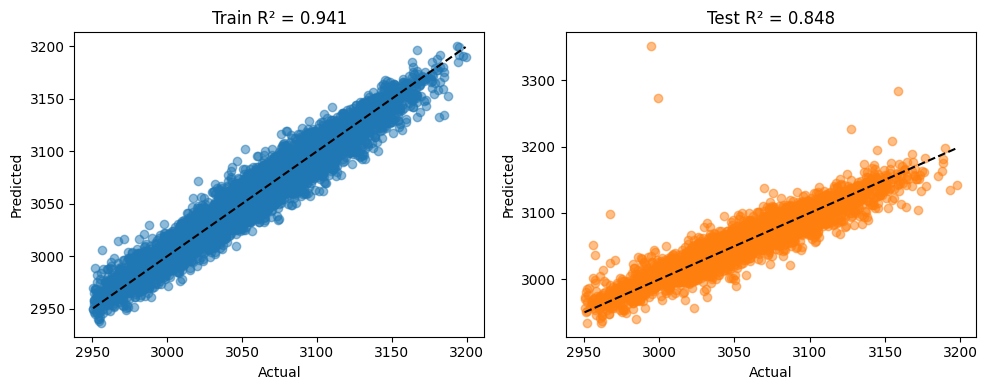

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import torch.nn.functional as F


def js_div(p, q, eps=1e-8):
    p_norm = F.softmax(p, dim=0)
    q_norm = F.softmax(q, dim=0)
    m = 0.5 * (p_norm + q_norm)
    kl_pm = torch.sum(p_norm * torch.log((p_norm + eps) / (m + eps)))
    kl_qm = torch.sum(q_norm * torch.log((q_norm + eps) / (m + eps)))
    return 0.5 * (kl_pm + kl_qm)


def custom_loss(y_pred, y_true, lam=0.5):
    mse = nn.MSELoss()(y_pred, y_true)
    y_max, y_min = y_true.max(), y_true.min()
    y_not = y_max + y_min - y_true
    D_js_y_yhat = js_div(y_true.squeeze(), y_pred.squeeze())
    D_js_y_ynot = js_div(y_true.squeeze(), y_not.squeeze())
    pmc_term = D_js_y_yhat / (D_js_y_ynot + 1e-8)
    return mse + lam * pmc_term


pmc_model = Net(X_train_t.shape[1]).to(device)
opt = torch.optim.AdamW(pmc_model.parameters(), lr=1e-3, weight_decay=1e-4)
sched = torch.optim.lr_scheduler.ReduceLROnPlateau(
    opt, factor=0.5, patience=20)

best_val, wait, patience = float('inf'), 0, 50

for epoch in range(1000):
    pmc_model.train()
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad()
        pred = pmc_model(xb)
        loss = custom_loss(pred, yb, lam=0.9)
        loss.backward()
        opt.step()

    pmc_model.eval()
    with torch.no_grad():
        val_pred_pmc = pmc_model(X_test_t.to(device)).cpu()
        val_loss_pmc = custom_loss(val_pred_pmc, y_test_t, lam=0.9).item()
    sched.step(val_loss_pmc)

    if val_loss_pmc < best_val:
        best_val, wait = val_loss_pmc, 0
        torch.save(pmc_model.state_dict(), 'best_pmc_nn.pt')
    else:
        wait += 1
        if wait > patience:
            print(f'Early stop @ {epoch} | best val loss {best_val:.4f}')
            break

    if epoch % 20 == 0:
        print(
            f'Epoch {epoch:4d} | train MSE {loss.item():.4f} | val MSE {val_loss_pmc:.4f}')

pmc_model.load_state_dict(torch.load('best_pmc_nn.pt'))
pmc_model.eval()
with torch.no_grad():
    y_train_pred_pmc = pmc_model(X_train_t.to(device)).cpu().numpy().ravel()
    y_test_pred_pmc = pmc_model(X_test_t.to(device)).cpu().numpy().ravel()

train_r2_pmc = r2_score(y_train, y_train_pred_pmc)
test_r2_pmc = r2_score(y_test,  y_test_pred_pmc)

plt.figure(figsize=(10, 4))

# Train
plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred_pmc, alpha=0.5, color='tab:blue')
lims = [y_train.min(), y_train.max()]
plt.plot(lims, lims, 'k--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'Train R² = {train_r2_pmc:.3f}')
plt.grid()


plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred_pmc, alpha=0.5, color='tab:orange')
lims = [y_test.min(), y_test.max()]
plt.plot(lims, lims, 'k--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'Test R² = {test_r2_pmc:.3f}')
plt.grid()

plt.tight_layout()
plt.show()

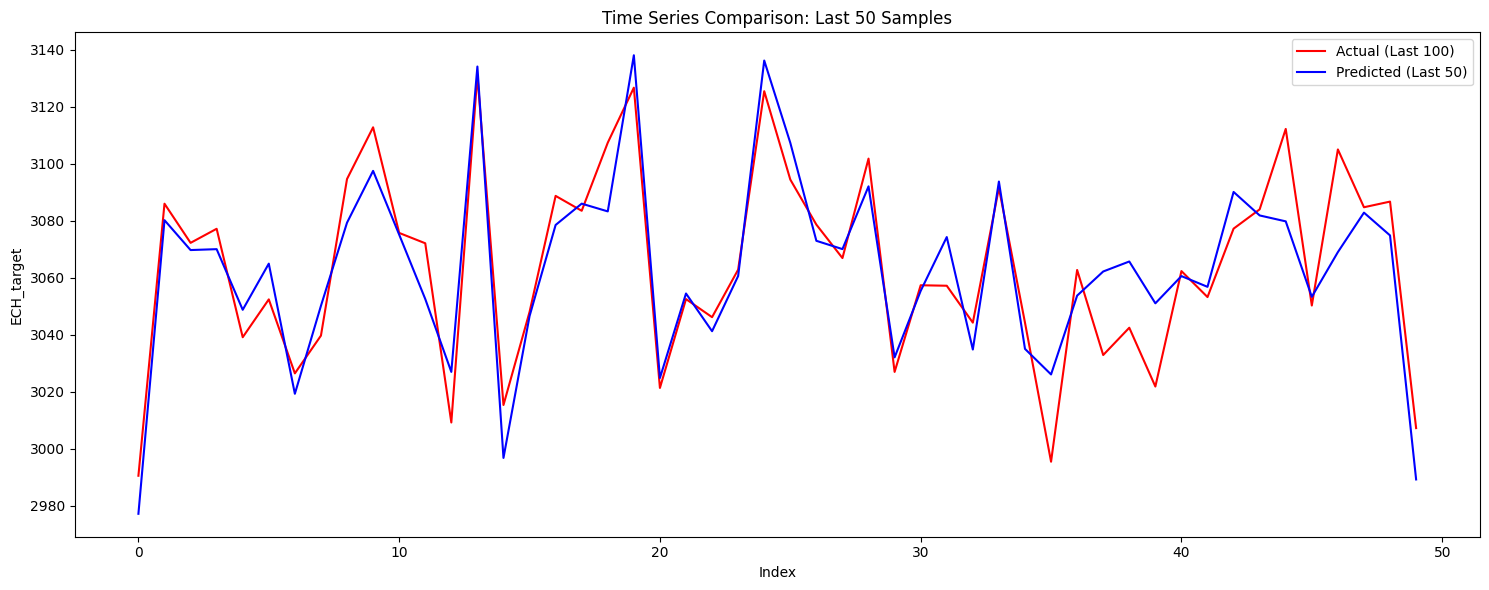

In [42]:
plt.figure(figsize=(15, 6))
plt.plot(y_test.reset_index(
    drop=True).values[-50:], label='Actual (Last 100)', color='red')
plt.plot(y_test_pred_pmc[-50:], label='Predicted (Last 50)', color='blue')
plt.title('Time Series Comparison: Last 50 Samples')
plt.xlabel('Index')
plt.ylabel('ECH_target')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# 3. Optimize the control values to maximize the ECH product

In [ ]:
df = pd.read_csv("chemical.csv")
X_all = df.drop(columns=["ECH_target"])
y_all = df["ECH_target"].reset_index(drop=True)

df_ctrl = pd.read_csv("chemical_control_features.csv")

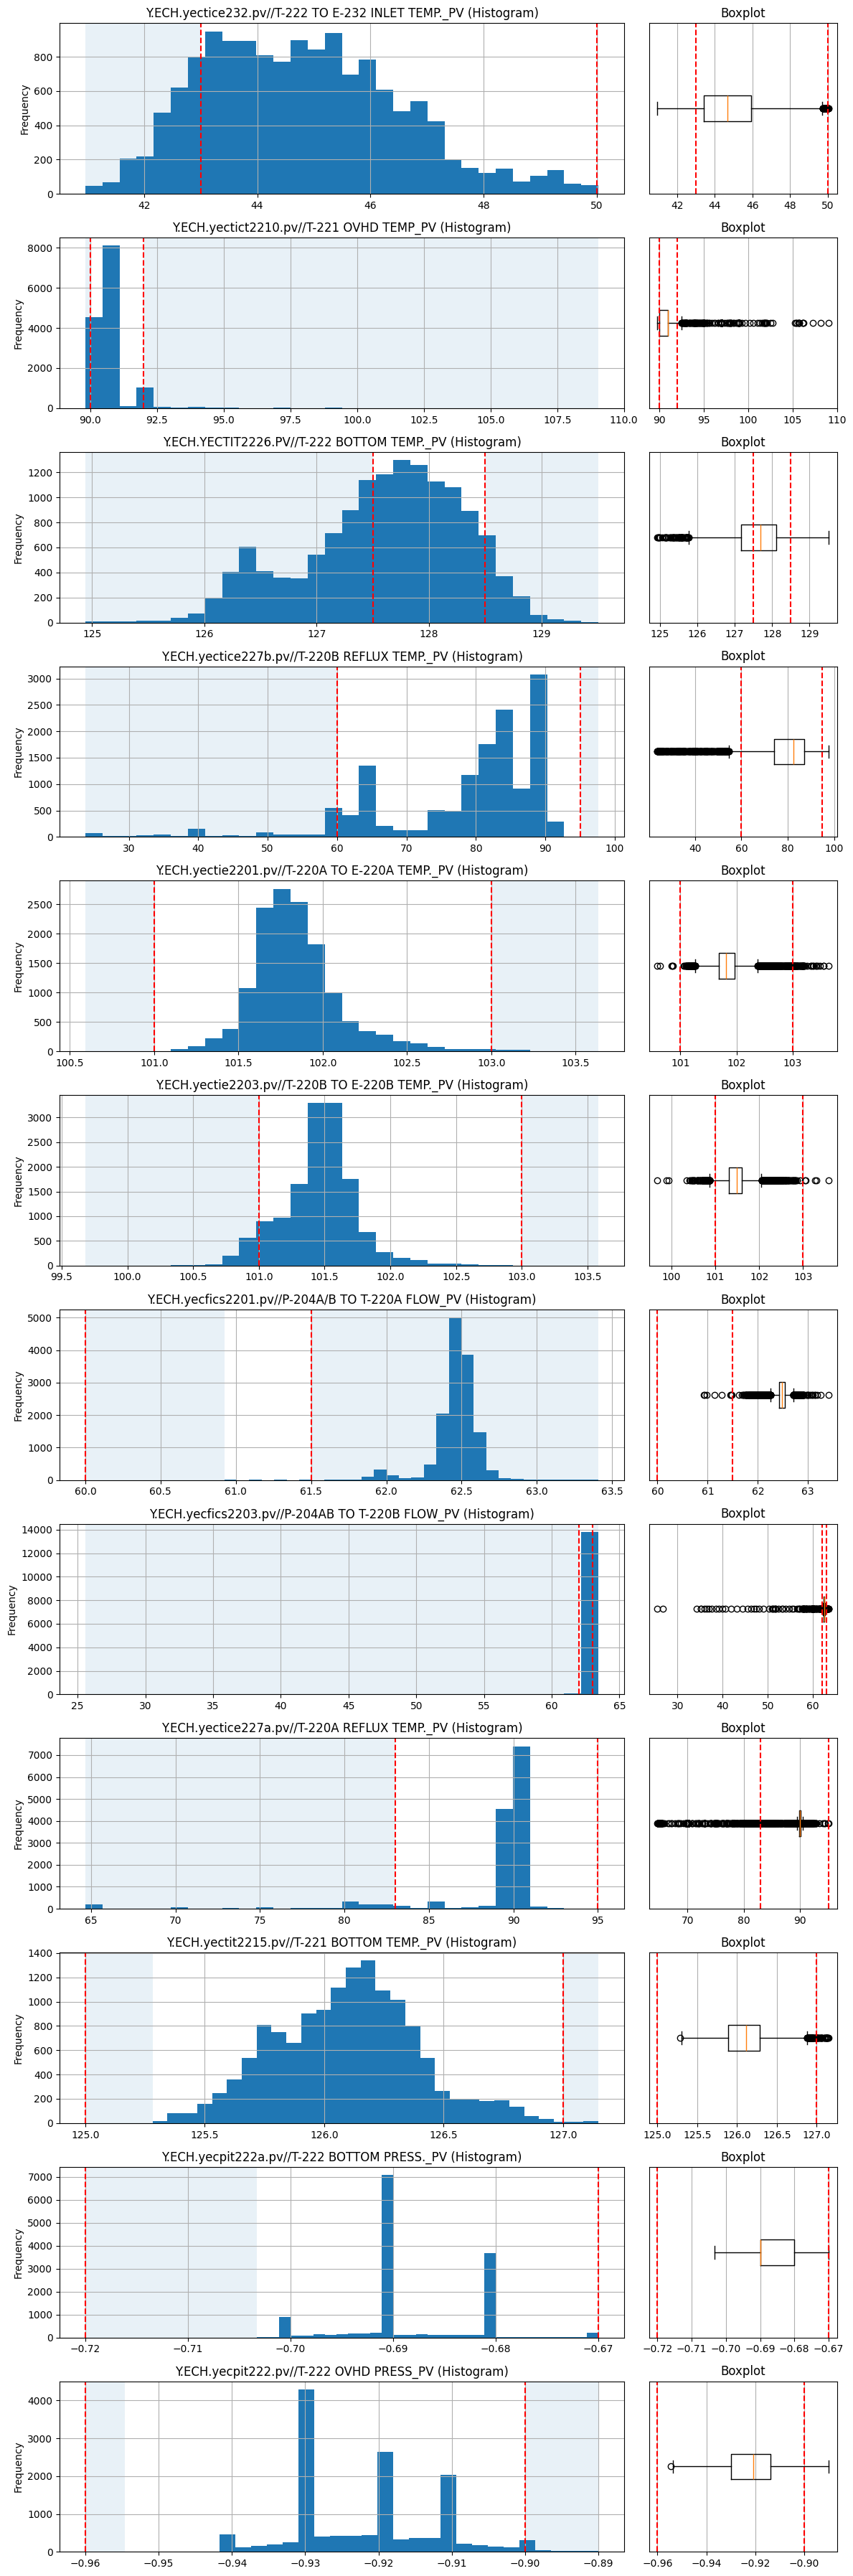

In [ ]:
summary_rows = []
for _, row in df_ctrl.iterrows():
    tag = row["tag"]
    min_val, max_val = row["min"], row["max"]
    series = df[tag]

    below_min = (series < min_val).sum()
    above_max = (series > max_val).sum()
    total = len(series)
    in_range = total - below_min - above_max

    summary_rows.append(
        {
            "Tag": tag,
            "Below Min": below_min,
            "Above Max": above_max,
            "In Range": in_range,
            "Total": total,
        }
    )

plt.rcParams.update({"axes.grid": True})

fig_rows = len(df_ctrl)
fig, axes = plt.subplots(
    nrows=fig_rows, ncols=2, figsize=(12, 3 * fig_rows), gridspec_kw={"width_ratios": [3, 1]}
)

for idx, row in df_ctrl.iterrows():
    tag = row["tag"]
    min_val, max_val = row["min"], row["max"]
    series = df[tag]

    ax_hist = axes[idx, 0]
    ax_hist.hist(series, bins=30)
    ax_hist.axvline(min_val, color="red", linestyle="--")
    ax_hist.axvline(max_val, color="red", linestyle="--")
    ax_hist.set_title(f"{tag} (Histogram)")

    ax_hist.axvspan(series.min(), min_val, alpha=0.1)
    ax_hist.axvspan(max_val, series.max(), alpha=0.1)
    ax_hist.set_ylabel("Frequency")

    ax_box = axes[idx, 1]
    ax_box.boxplot(series, vert=False)
    ax_box.axvline(min_val, color="red", linestyle="--")
    ax_box.axvline(max_val, color="red", linestyle="--")
    ax_box.set_title("Boxplot")
    ax_box.set_yticks([])

plt.tight_layout()
plt.show()

summary_df = pd.DataFrame(summary_rows)

In [ ]:
control_tags = df_ctrl['tag'].tolist()
control_indices = [tag for tag in X_all.columns if tag in control_tags]
bounds = [tuple(df_ctrl[df_ctrl['tag'] == tag][['min', 'max']].values[0])
          for tag in control_indices]

scaler = StandardScaler().fit(X_all)

pmc_model.eval()


optimized_preds = []
optimized_controls = []

for i in range(len(X_all)):
    env_row = X_all.iloc[i].copy()

    def objective(control_vals):
        x_input = env_row.copy()
        for j, tag in enumerate(control_indices):
            x_input[tag] = control_vals[j]
        x_scaled = scaler.transform(pd.DataFrame([x_input]))
        x_tensor = torch.tensor(x_scaled, dtype=torch.float32).to(device)
        with torch.no_grad():
            pred = pmc_model(x_tensor).cpu().item()
        return -pred

    x0 = np.array([env_row[tag] for tag in control_indices])
    res = minimize(objective, x0=x0, bounds=bounds, method='L-BFGS-B')
    optimized_preds.append(-res.fun)
    optimized_controls.append(res.x)

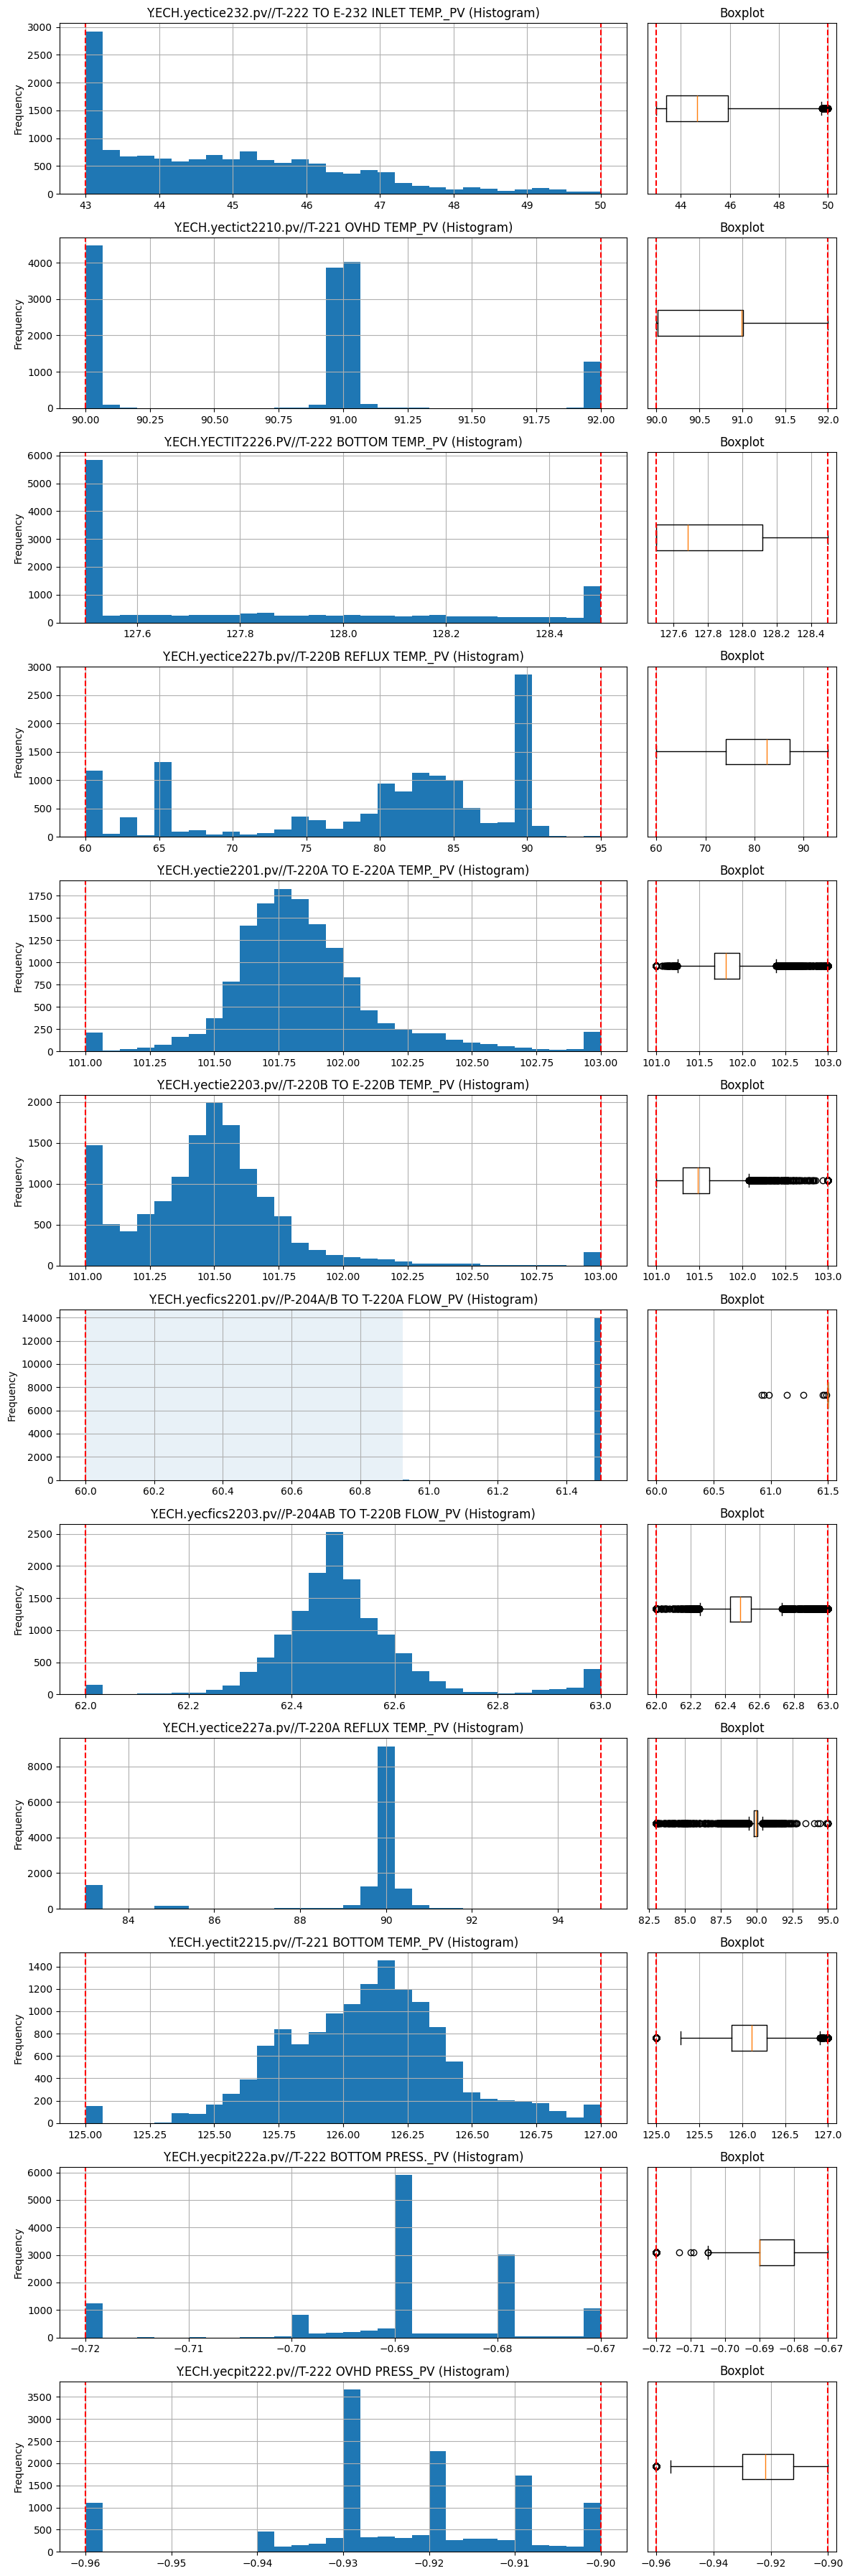

                                                  Tag  Below Min  Above Max  \
0   Y.ECH.yectice232.pv//T-222 TO E-232 INLET TEMP...          0          0   
1            Y.ECH.yectict2210.pv//T-221 OVHD TEMP_PV          0          0   
2          Y.ECH.YECTIT2226.PV//T-222 BOTTOM TEMP._PV          0          0   
3        Y.ECH.yectice227b.pv//T-220B REFLUX TEMP._PV          0          0   
4      Y.ECH.yectie2201.pv//T-220A TO E-220A TEMP._PV          0          0   
5      Y.ECH.yectie2203.pv//T-220B TO E-220B TEMP._PV          0          0   
6    Y.ECH.yecfics2201.pv//P-204A/B TO T-220A FLOW_PV          0          0   
7     Y.ECH.yecfics2203.pv//P-204AB TO T-220B FLOW_PV          0          0   
8        Y.ECH.yectice227a.pv//T-220A REFLUX TEMP._PV          0          0   
9          Y.ECH.yectit2215.pv//T-221 BOTTOM TEMP._PV          0          0   
10        Y.ECH.yecpit222a.pv//T-222 BOTTOM PRESS._PV          0          0   
11            Y.ECH.yecpit222.pv//T-222 OVHD PRESS_P

In [46]:
df_opt = df.copy()
for i, tag in enumerate(control_indices):
    df_opt[tag] = np.array(optimized_controls)[:, i]

summary_rows = []
fig, axes = plt.subplots(nrows=len(df_ctrl), ncols=2, figsize=(
    12, 3 * len(df_ctrl)), gridspec_kw={"width_ratios": [3, 1]})
plt.rcParams.update({"axes.grid": True})

for idx, row in df_ctrl.iterrows():
    tag = row["tag"]
    min_val, max_val = row["min"], row["max"]
    series = df_opt[tag]

    below = (series < min_val).sum()
    above = (series > max_val).sum()
    total = len(series)
    in_range = total - below - above

    summary_rows.append({
        "Tag": tag,
        "Below Min": below,
        "Above Max": above,
        "In Range": in_range,
        "Total": total
    })

    ax_hist = axes[idx, 0]
    ax_hist.hist(series, bins=30)
    ax_hist.axvline(min_val, color="red", linestyle="--")
    ax_hist.axvline(max_val, color="red", linestyle="--")
    ax_hist.set_title(f"{tag} (Histogram)")
    ax_hist.axvspan(series.min(), min_val, alpha=0.1)
    ax_hist.axvspan(max_val, series.max(), alpha=0.1)
    ax_hist.set_ylabel("Frequency")

    ax_box = axes[idx, 1]
    ax_box.boxplot(series, vert=False)
    ax_box.axvline(min_val, color="red", linestyle="--")
    ax_box.axvline(max_val, color="red", linestyle="--")
    ax_box.set_title("Boxplot")
    ax_box.set_yticks([])

plt.tight_layout()
plt.show()

summary_df = pd.DataFrame(summary_rows)
print(summary_df)

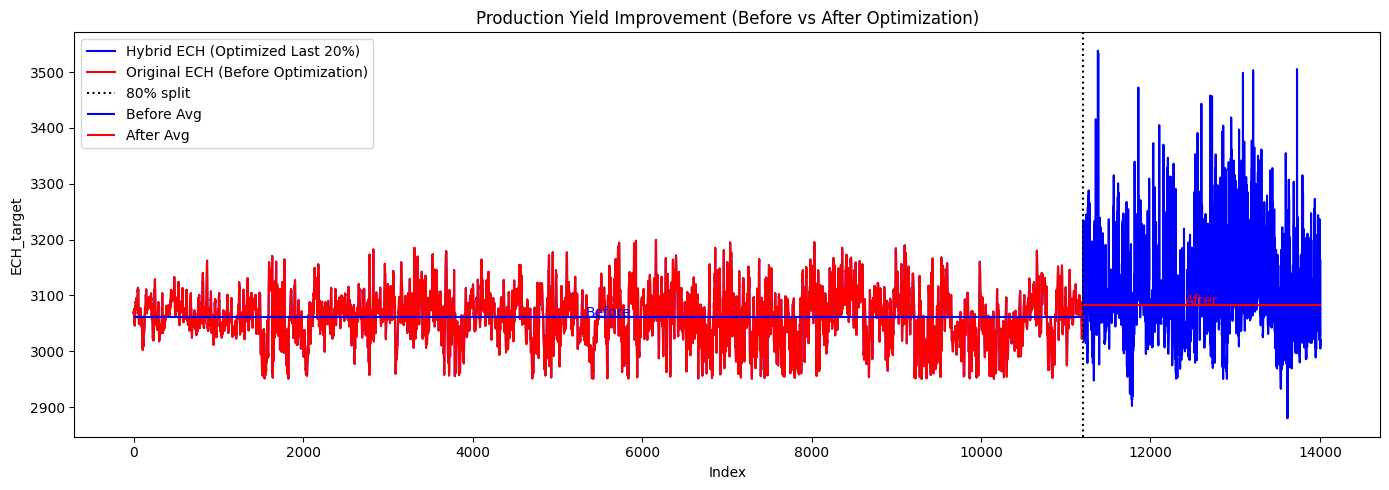

In [ ]:
split_idx = int(0.8 * len(X_all))

original_series = y_all.values[:split_idx]
hybrid_series = np.concatenate([
    y_all.values[:split_idx],
    np.array(optimized_preds)[split_idx:]
])


mean_before = np.mean(y_all.values[:split_idx])
mean_after = np.mean(optimized_preds[split_idx:])

plt.figure(figsize=(14, 5))
plt.plot(hybrid_series, label="Hybrid ECH (Optimized Last 20%)", color='blue')
plt.plot(original_series, label="Original ECH (Before Optimization)", color='red')
plt.axvline(split_idx, color='black', linestyle=':', label="80% split")
plt.hlines(mean_before, 0, split_idx, color='blue',
           linestyle='-', label="Before Avg")
plt.hlines(mean_after, split_idx, len(y_all),
           color='red', linestyle='-', label="After Avg")
plt.text(split_idx / 2, mean_before + 0.3, 'Before', color='blue', ha='center')
plt.text(split_idx + (len(y_all) - split_idx)/2,
         mean_after + 0.3, 'After', color='red', ha='center')
plt.title("Production Yield Improvement (Before vs After Optimization)")
plt.xlabel("Index")
plt.ylabel("ECH_target")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()